In [1]:
DATASET_PATH = 'images' # Исходный набор невыровненных изображений номеров
MODEL_PATH = 'resnet18_letters.pth' # Предоставленная модель

Вам предстоит создать алгоритм по деформации (выравниваню) автомобильных номеров и поместить его в функцию img_deformation.


! Вы не можете менять заданную OCR модель (дообучать тоже нельзя) и заданные шаблоны по разбиению изображения.

! Допустимы небольшие измениния трех основных .py файлов, если в этом есть необходимость для встраивания в ваши решения. Но их функционал должен быть сохранен.

# Файлы для работы с шаблонами

В разделе "Алогритм" показано что для чего нужно, так что имеет смысл сначала посетить его

## model.py

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18

label2letter = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "E", 14: "H", 15: "K", 16: "M", 17: "O", 18: "P", 19: "T", 20: "X", 21: "Y"
}

class LettersPrediction(object):
    def __init__(self):
        self.model = resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features=22)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cuda')))
        self.model.eval()

        self.imgsz = 64

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.imgsz, self.imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img):
        input_tensor = self.transform(img)
        output_tensor = self.model(input_tensor.unsqueeze(0))
        predicted = torch.argmax(output_tensor)
        return label2letter[predicted.item()]

    def predict_series(self, imgs):
        s = ""
        for img in imgs:
            s += self.predict(img)
        return s

C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## template.py

Разбивает изображение на части по шаблонам

In [3]:
from pathlib import Path
import numpy as np

two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]

three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

def apply_template(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    crops = []
    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = sx * W, sy * H, ex * W, ey * H
        sx, sy, ex, ey = map(int, [sx, sy, ex, ey])
        crops.append(img[sy : ey, sx : ex])

    return crops


## Функция для деформации

Пропишите логику алгоритма по деформации внутри фунции img_deformation

In [4]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import glob
import random
import matplotlib.pyplot as plt
import numpy as np

# Определение модели для вычисления угловых точек невыровненного номера
class LicensePlateModel(nn.Module):
    def __init__(self):
        super(LicensePlateModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 16, 128)
        self.fc2 = nn.Linear(128, 8)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batchNorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchNorm2(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 16)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x


model_border = torch.load('border_model_128.pth').cuda()
model_border.eval()

# Функция для преобразования изображения в тензор и нормализации
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((28, 128)),
        transforms.ToTensor(),
    ])
    return preprocess(image).unsqueeze(0)

# Функция для предсказания угловых точек
def predict_corners(model_border, image):
    with torch.no_grad():
        input_tensor = preprocess_image(image)
        output = model_border(input_tensor.cuda()).squeeze().cpu().numpy()
        # Деконвертация координат из нормализованного диапазона [0, 1] в координаты пикселей
        h, w, _ = image.shape
        corners = output.reshape(4, 2) * [w, h]
        return corners

# Функция для выравнивания изображения
def align_image(image, corners):
    rect = np.zeros((4, 2), dtype="float32")
    s = corners.sum(axis=1)
    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]
    
    diff = np.diff(corners, axis=1)
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]
    
    (tl, tr, br, bl) = rect
    
    for i, point in enumerate([tl, tr, br, bl]):
        if not np.isfinite(point).all():
            print(f"Warning: Point {i} is not finite: {point}")
            return None
        
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    aligned = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return aligned

# Функция для деформации изображения
def img_deformation(image):
    global model_border
    corners = predict_corners(model_border, image)
    aligned_image = align_image(image, corners)
    return aligned_image

## predict.py

Выполняет предсказание для изображений разбитых по 2 и 3 шаблону

# Загрузка моделей

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
import os


# Модель для определения формата номера региона (двух- или трёхзначный)
#  2 класса: 0 - 2 символа, 1 - 3 символа
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 30 * 15, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 15)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Загрузка модели
model_reg = torch.load('model_weights.pth')
model_reg.eval()

# Функция для предсказания на изображении
def predict_image_reg(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((60, 120)),
        transforms.ToTensor()
    ])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование BGR изображения OpenCV в RGB
    image = transform(image).unsqueeze(0)  # Применение преобразований и добавление измерения batch
    with torch.no_grad():
        outputs = model_reg(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Функция для извлечения фрагментов
def extract_fragments(image, template):
    height, width = image.shape[:2]
    imgs = []
    for region in template:
        p1 = (int(region['p1'][0] * width), int(region['p1'][1] * height))
        p2 = (int(region['p2'][0] * width), int(region['p2'][1] * height))
        fragment = image[p1[1]:p2[1], p1[0]:p2[0]]
        
        fragment = cv2.resize(fragment, (50, 70))
        imgs.append(fragment)
    return imgs

# Определение модели для уточнения положения символа в трафарете
# 3 класса: 0 - трафарет нужно сместить влево; 1 - символ по центру, ничего не меняем; 2 - трафарет нужно сместить вправо
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)
    
    def forward(self, x):
        x = self.batchNorm1(self.pool(F.relu(self.conv1(x))))
        x = self.batchNorm2(self.pool(F.relu(self.conv2(x))))
        x = self.batchNorm3(self.pool(F.relu(self.conv3(x))))
        x = x.view(-1, 64 * 8 * 8) 
        x = self.drop(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Загрузка модели
model_loc = torch.load('model_weights_loc.pth')
model_loc.eval()

W, H = 64, 64

# Функция для предсказания на изображении
def predict_image_loc(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((H, W)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.ColorJitter(contrast=1.5),
    ])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразование BGR изображения OpenCV в RGB
    image = transform(image).unsqueeze(0)  # Применение преобразований и добавление измерения batch
    with torch.no_grad():
        outputs = model_loc(image.cuda())
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

In [7]:
import argparse
from pathlib import Path
from tqdm import tqdm
import cv2
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import copy

data_path = Path(DATASET_PATH)
regions_type = [2, 3]
model = LettersPrediction()
result = []
# Нормализованные координаты номера региона
relative_coordinates = (0.71, 0.05, 0.96, 0.7)
   
def process_image(p):
    if not p.suffix in [".png", ".jpg", ".jpeg"]:
        return None
    img_result = {
        "image_name": p.stem
    }
    img = cv2.imread(str(p))

    #вызов фунции деформации
    img = img_deformation(img)
    # Вырезание номера региона для подачи на вход сети, определяющей его длину (2 или 3 символа)
    height, width, _ = img.shape
    left = int(relative_coordinates[0] * width)
    top = int(relative_coordinates[1] * height)
    right = int(relative_coordinates[2] * width)
    bottom = int(relative_coordinates[3] * height)
        
    # Обрезаем изображение
    crop_img = img[top:bottom, left:right]
    # Определяем формат номера региона 
    reg = predict_image_reg(crop_img)
    # Применяем подходящий набор трафаретов
    if reg == 0:
        fragments = extract_fragments(img, two_digit_region_template)
        current_template = copy.deepcopy(two_digit_region_template)
    elif reg == 1:
        fragments = extract_fragments(img, three_digit_region_template)
        current_template = copy.deepcopy(three_digit_region_template)
    
    # Проходимся в цикле по всем изображениям и сдвигаем трафареты
    limit = 10
    step = 0.015
    for i, fragment in enumerate(fragments):
        prediction = predict_image_loc(fragment)
        if prediction == 1:
            continue
        elif prediction == 0:
            count = 0
            while prediction != 1 and count < limit:
                temp = [current_template[i]]
                temp[0]['p1'] = (temp[0]['p1'][0] - step, temp[0]['p1'][1])
                temp[0]['p2'] = (temp[0]['p2'][0] - step, temp[0]['p2'][1])
                if temp[0]['p1'][0] < 0 or temp[0]['p2'][0] < 0 or temp[0]['p1'][1] > 1 or temp[0]['p2'][1] > 1:
                    break
                fragment = extract_fragments(img, temp)[0]
                prediction = predict_image_loc(fragment)
                count += 1


        elif prediction == 2:
            count = 0
            while prediction != 1 and count < limit:
                temp = [current_template[i]]
                temp[0]['p1'] = (temp[0]['p1'][0] + step, temp[0]['p1'][1])
                temp[0]['p2'] = (temp[0]['p2'][0] + step, temp[0]['p2'][1])
                if temp[0]['p1'][0] < 0 or temp[0]['p2'][0] < 0 or temp[0]['p1'][1] > 1 or temp[0]['p2'][1] > 1:
                    break
                fragment = extract_fragments(img, temp)[0]
                prediction = predict_image_loc(fragment)
                count += 1
        fragments[i] = fragment
    
#     img = cv2.resize(img, (512, 112))
    
    lp_number = model.predict_series(fragments)
    img_result[f"prediction_region_length_2"] = lp_number
    img_result[f"prediction_region_length_3"] = lp_number
    
    return img_result

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_image, p): p for p in data_path.iterdir()}
    for future in tqdm(as_completed(futures), total=len(futures)):
        img_result = future.result()
        if img_result is not None:
            result.append(img_result)
            
# for p in data_path.iterdir():
#     result.append(process_image(p))

pd.DataFrame(result).to_csv('modelPredict.csv', index=False)


  0%|          | 0/1029 [00:00<?, ?it/s]C:\Users\mmill\AppData\Local\anaconda3\envs\hac\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1029/1029 [00:38<00:00, 26.98it/s]


# Алгоритм

![](https://sun9-2.userapi.com/impg/SfgCnkIYJeC_4clAh69dvC6ZwmBT9dLmMkh25A/DvScgey4ZCg.jpg?size=1916x1079&quality=96&sign=2ef5e9fadc1d8635c4963fb99affd07d&type=album)

In [7]:
import pandas as pd

# Загрузка CSV файлов
predicted_df = pd.read_csv('modelPredict.csv')
correct_df = pd.read_csv('correspondance.csv')

# Проверка совпадений и подсчет точности
correct_count = 0

# Объединение данных по имени файла
merged_df = pd.merge(predicted_df, correct_df, on='image_name', how='inner')

# Добавление столбца для проверки совпадений
merged_df['is_correct'] = (merged_df['number'] == merged_df['prediction'])

# Подсчет количества правильных распознаваний
correct_count = merged_df['is_correct'].sum()
total_count = len(merged_df)

# Вычисление точности
accuracy = correct_count / total_count * 100

print(f'Accuracy: {accuracy:.2f}%')

# Сохранение объединенного DataFrame для проверки
merged_df[['image_name', 'number', 'prediction', 'is_correct']].to_csv('merged_results.csv', index=False)

# Вывод результатов
merged_df[['image_name', 'number', 'prediction', 'is_correct']]

Accuracy: 61.90%


,image_name,number,prediction,is_correct
0,030e79615dc8d57b,B626YP64,B626MP64,False
1,0556dd00e20e7977,O905KO60,O905KO60,True
2,002d28e4d47606a2,X051MO51,X051MO51,True
3,049df008076b541f,O009HB39,O009HB39,True
4,00c980fd3135c4af,P817KT60,P81TCT60,False
...,...,...,...,...
1024,fe8f3cff0cf76166,Y929EE64,Y929EE64,True
1025,ffdab76d3e777688,B061BX82,B061BX82,True
1026,ff670e356ab0fee5,A965OT150,A965OT150,True
1027,fed01b5793ae24dc,M614HO178,M614HOC78,False


Accuracy: 61.90%


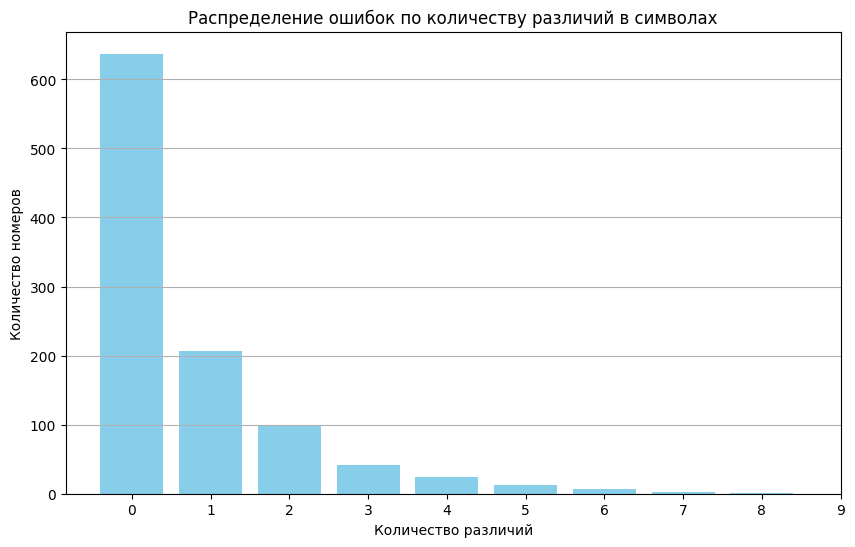

,image_name,number,prediction
0,030e79615dc8d57b,B626YP64,B626MP64
1,0556dd00e20e7977,O905KO60,O905KO60
2,002d28e4d47606a2,X051MO51,X051MO51
3,049df008076b541f,O009HB39,O009HB39
4,00c980fd3135c4af,P817KT60,P81TCT60
...,...,...,...
1024,fe8f3cff0cf76166,Y929EE64,Y929EE64
1025,ffdab76d3e777688,B061BX82,B061BX82
1026,ff670e356ab0fee5,A965OT150,A965OT150
1027,fed01b5793ae24dc,M614HO178,M614HOC78


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка CSV файлов
predicted_df = pd.read_csv('modelPredict.csv')
correct_df = pd.read_csv('correspondance.csv')

# Объединение данных по имени файла
merged_df = pd.merge(predicted_df, correct_df, on='image_name', how='inner')

# Функция для подсчета различий между двумя строками
def count_differences(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2)) + abs(len(s1) - len(s2))

# Подсчет различий и проверка совпадений
merged_df['differences'] = merged_df.apply(lambda row: count_differences(row['number'], row['prediction']), axis=1)
# merged_df['min_differences'] = merged_df[['differences_1', 'differences_2']].min(axis=1)

# Подсчет количества правильных распознаваний
correct_count = merged_df[merged_df['differences'] == 0].shape[0]
total_count = len(merged_df)

# Вычисление точности
accuracy = correct_count / total_count * 100

print(f'Accuracy: {accuracy:.2f}%')

# Подсчет количества ошибок по количеству различий
differences_count = merged_df['differences'].value_counts().sort_index()

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.bar(differences_count.index, differences_count.values, color='skyblue')
plt.xlabel('Количество различий')
plt.ylabel('Количество номеров')
plt.title('Распределение ошибок по количеству различий в символах')
plt.xticks(range(0, 10))
plt.grid(axis='y')
plt.show()

# Сохранение объединенного DataFrame для проверки
merged_df[['image_name', 'number', 'prediction']].to_csv('merged_results.csv', index=False)

# Вывод результатов
merged_df[['image_name', 'number', 'prediction']]


In [ ]:
import matplotlib.pyplot as plt
import os

#Рисует на изображение template
def draw_regions(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = int(sx * W), int(sy * H), int(ex * W), int(ey * H)
        cv2.rectangle(img, (sx, sy), (ex, ey), (0, 255, 0), 2)

    return img

#Визуализирует изображения из датасета
def draw(folder_path, show_template=False, template=2):

    file_list = os.listdir(folder_path)[:5]
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Устанавливаем количество изображений на строку
    images_per_row = 5

    num_rows = len(image_files) // images_per_row + int(len(image_files) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(image_files):
            ax = axes.flat[i]
            img_path = os.path.join(folder_path, image_files[i])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if show_template:
              img = img_deformation(img)
              img = cv2.resize(img, (512,112))
              img_with_rectangles = draw_regions(img, template)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()


Визуализируем изображения из датасета

In [ ]:
draw(DATASET_PATH, show_template=False)

Теперь визуализируем шаблон 2 для каждого изображения

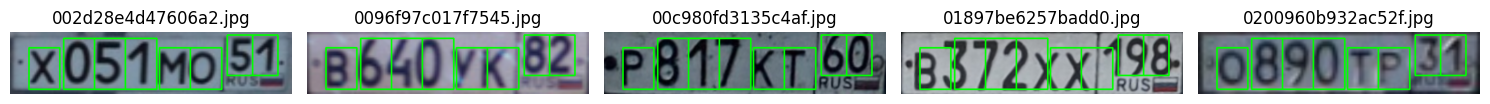

In [10]:
draw(DATASET_PATH, show_template=True)

Теперь визуализируем шаблон 3 для каждого изображения

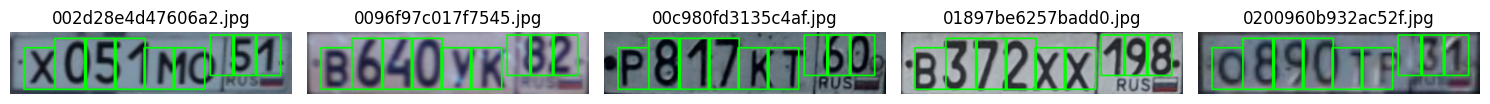

In [11]:
draw(DATASET_PATH, show_template=True, template = 3)

# Вывод модели

In [ ]:
df = pd.read_csv('modelPredict.csv')

Модель делает предсказание разбивая изображение и по шаблону 2 и по шаблону 3.

In [ ]:
df